In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pandas import DataFrame, read_csv, to_datetime, concat
from sklearn.feature_selection import chi2, SelectKBest
from nltk.tokenize import TweetTokenizer as tokenizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from numpy import array, vectorize, arange
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.text import Text
from nltk import FreqDist
from os import listdir
from cmath import nan

#### dataset.py

In [2]:
class parameters_model:
    def __init__(self) -> None:
        self.define_paths()
        self.define_graphics_parameters()

    def define_paths(self):
        """
        Localizacion de los archivos de datos, resultados y graficas
        """
        self.parameters = {"path data": "../Data/",
                           "path results": "../Results/",
                           "path graphics": "../Graphics/"}

    def define_graphics_parameters(self):
        """
        Parametros para los histogramas de cada lugar
        """
        self.graphics = {"Alhóndiga": {"y lim": 35,
                                       "y delta": 5},
                         "Basilica Colegiata": {"y lim": 20,
                                                "y delta": 2},
                         "Callejón del Beso": {"y lim": 50,
                                               "y delta": 5},
                         "Casa de Diego Rivera": {"y lim": 20,
                                                  "y delta": 2},
                         "Jardín de la Unión": {"y lim": 35,
                                                "y delta": 5},
                         "Mercado Hidalgo": {"y lim": 25,
                                             "y delta": 5},
                         "Monumento Pípila": {"y lim": 60,
                                              "y delta": 5},
                         "Museo de las Momias": {"y lim": 60,
                                                 "y delta": 5},
                         "Teatro Juárez": {"y lim": 35,
                                           "y delta": 5},
                         "Universidad de Guanajuato": {"y lim": 35,
                                                       "y delta": 5}}

#### functions.py

In [3]:
def join_path(path: str, filename: str) -> str:
    """
    Une la direccion de un archivo con su nombre
    """
    return "{}{}".format(path, filename)


def obtain_name_place_from_filename(filename: str) -> str:
    """
    Obtiene el nombre del lugar en base a su nombre
    """
    name = filename.split(".")[0]
    name = name.split("_")
    name = " ".join(name)
    return name


def obtain_best_features(bow: array, labels: array, k: int = 1000) -> list:
    features = SelectKBest(chi2, k=k)
    features.fit(bow, labels)
    best_features = features.get_support(indices=True)
    return best_features, features.scores_


def obtain_target_matrix(index: dict, data: array, best_features: array) -> array:
    invert_index = {}
    for word in index:
        invert_index[index[word]] = word
    target_words = [invert_index[word] for word in best_features]
    target_matrix = array([data[index[word]] for word in target_words])
    return target_words, target_matrix


def ls(path: str) -> list:
    files = sorted(listdir(path))
    files = [file for file in files if "." in file]
    return files


def concat_dataframes(data_1: DataFrame, data_2: DataFrame) -> DataFrame:
    data = concat([data_1, data_2])
    data.index = range(len(data))
    return data

#### tripádvisor.py

In [28]:
class tripadvisor_model:
    def __init__(self, dataset: parameters_model) -> None:
        self.parameters = dataset.parameters
        self.age_range = {"Joven": [10, 30],
                          "Mayor": [31, 100]}

    def read_data(self,  name: str) -> DataFrame:
        """
        Lectura de los datos y formateo de la fecha dado el nombre del archivo
        """
        # Nombre con la ruta del archivo
        filename = join_path(self.parameters["path data"],
                             name)
        #  Lectura de los datos
        data = read_csv(filename)
        # Formato de los datos
        self.data = self.format_data(data)

    def format_data(self, data: DataFrame) -> DataFrame:
        """
        Formato de fecha a todo el dataframe
        """
        data = self.format_date(data)
        data = self.obtain_new_scala_of_scores(data)
        data = self.clean_text(data)
        return data

    def format_date(self, data: DataFrame) -> DataFrame:
        data["Fecha"] = data["Fecha"].astype(str).str.split("/")
        data["Fecha"] = data["Fecha"].apply(self.date_format)
        data["Fecha"] = to_datetime(data["Fecha"])
        return data

    def clean_text(self, data: DataFrame) -> DataFrame:
        columns = ["Título de la opinión", "Opinión"]
        for column in columns:
            data[column] = data[column].astype(str).str.replace('"', "")
            data[column] = data[column].astype(str).str.lower()
        return data

    def obtain_word_length_per_opinion(self) -> None:
        """
        Obtiene la cantidad de palabras por opinion
        """
        self.data["Word length"] = self.data["Opinión"].astype(str).str.split()
        self.data["Word length"] = self.data["Word length"].apply(len)

    def obtain_new_scala_of_scores(self, data: DataFrame) -> DataFrame:
        data["new scale"] = data["Escala"].apply(self.new_scala_of_scores)
        return data

    def new_scala_of_scores(self, score: int) -> int:
        if score in [4, 5]:
            return 2
        if score in [3]:
            return 1
        if score in [1, 2]:
            return 0

    def date_format(self, date: list) -> str:
        """
        Formate de fecha de listas [dia,mes,año] a año-mes-dia
        """
        day = date[0].zfill(2)
        month = date[1].zfill(2)
        year = date[2]
        date = "{}-{}-{}".format(year,
                                 month,
                                 day)
        return date

    def select_data_per_gender(self, gender: str) -> DataFrame:
        self.data_select = self.data[self.data["Género"] == gender]

    def select_data_per_nationality(self, nationality: str) -> DataFrame:
        self.data_select = self.data[self.data["Nacional ó Internacional"] == nationality]

    def select_data_per_age_range(self, age_range: str) -> DataFrame:
        age_range = self.age_range[age_range]
        self.data_select = self.data[self.data["Edad"] >= age_range[0]]
        self.data_select = self.data_select[self.data_select["Edad"]
                                            <= age_range[1]]

    def obtain_daily_counts_of_scores(self) -> DataFrame:
        results = {}
        result_basis = {0: 0,
                        1: 0,
                        2: 0}
        dates = sorted(list(set(self.data["Fecha"])))
        for date in dates:
            data_per_day = self.data[self.data["Fecha"] == date]
            data_counts = data_per_day["new scale"].value_counts()
            results[date] = result_basis.copy()
            for value in data_counts.index:
                results[date][value] = data_counts[value]
        results = DataFrame(results)
        self.daily_scores_counts = results.transpose()

    def obtain_yearly_stadistics_of_scores(self) -> DataFrame:
        self.obtain_daily_counts_of_scores()
        yearly_scores = self.daily_scores_counts.resample("Y").sum()
        for date in yearly_scores.index:
            year_sum = yearly_scores.loc[date].sum()
            if year_sum != 0:
                yearly_scores.loc[date] = yearly_scores.loc[date]/year_sum
            else:
                yearly_scores.loc[date] = nan
        yearly_mean_data = self.data.resample("Y", on="Fecha").mean()
        yearly_std_data = self.data.resample("Y", on="Fecha").std()
        self.yearly_data = concat([yearly_scores,
                                   yearly_mean_data["Escala"],
                                   yearly_std_data["Escala"]],
                                  axis=1)
        self.yearly_data.columns = [0, 1, 2, "Escala mean", "Escala std"]

    def obtain_monthly_stadistics_of_scores(self) -> DataFrame:
        self.obtain_daily_counts_of_scores()
        monthly_scores = self.daily_scores_counts.resample("MS").sum()
        for date in monthly_scores.index:
            monthly_sum = monthly_scores.loc[date].sum()
            if monthly_sum != 0:
                monthly_scores.loc[date] = monthly_scores.loc[date]/monthly_sum
            else:
                monthly_scores.loc[date] = nan
        monthly_mean_data = self.data.resample("MS", on="Fecha").mean()
        monthly_std_data = self.data.resample("MS", on="Fecha").std()
        self.monthly_data = concat([monthly_scores,
                                   monthly_mean_data["Escala"],
                                   monthly_std_data["Escala"]],
                                   axis=1)
        self.monthly_data.columns = [0, 1, 2, "Escala mean", "Escala std"]

    def obtain_only_negatives_scores(self):
        self.data_select = self.data[self.data["new scale"] == 0]
        if len(self.data_select) < 10:
            self.data_select = self.data[self.data["new scale"] != 2]

    def sort_by_date(self):
        self.data = self.data.sort_values(by="Fecha")

    def obtain_opinions_as_text(self, stopwords: list) -> Text:
        vectorizer = CountVectorizer(stop_words=stopwords)
        tokenizer = vectorizer.build_tokenizer()
        opinions = " ".join(self.data["Opinión"])
        opinions = tokenizer(opinions)
        opinions = Text(opinions)
        return opinions

#### vocabulary.py

In [5]:
class vocabulary_class:
    def __init__(self, max_words: int = 5000) -> None:
        self.vectorizer = CountVectorizer()
        self.tokenizer = tokenizer().tokenize
        self.max_words = max_words
        self.stopwords = self.obtain_stopwords()

    def obtain_stopwords(self):
        stopwords_list = stopwords.words("spanish")
        stopwords_list += stopwords.words("english")
        stopwords_list += [".", ",", "...", "!", "(", ")", "¡", "-", ":"]
        return set(stopwords_list)

    def obtain(self, tripadvisor: tripadvisor_model, data_select: bool = False) -> list:
        """
        Obtiene la lista de una distribucion de frecuencias de palabras ordenada de mayor a menor a partir de una lista de oraciones
        """
        # Inicializacion de la lista que guardara los tokens
        corpus = []
        if data_select:
            data = tripadvisor.data_select
        else:
            data = tripadvisor.data
        for oration in data["Opinión"]:
            tokens = self.tokenizer(oration)
            tokens = [
                token for token in tokens if not token in self.stopwords]
            corpus += tokens
        # Creacion de la distribucion de frecuencias
        vocabylary = FreqDist(corpus)
        vocabylary = self.sort_freqdist(vocabylary)
        vocabylary = self.split_data(vocabylary)
        return vocabylary

    def sort_freqdist(self, vocabylary: FreqDist) -> list:
        """
        Ordena la lista de distribucion de frecuencias de palabras de mayor frecuencia a menor
        """
        aux = [(vocabylary[key], key) for key in vocabylary]
        aux.sort()
        aux.reverse()
        return aux

    def split_data(self, data: list) -> list:
        """
        Realiza la separacion de elementos en una lista dado el numero de elementos que se quieren conservar
        """
        return data[:self.max_words]

#### LSA.py

In [6]:
class LSA:
    def __init__(self, bow: array, words: list, n_components: int) -> None:
        self.n_components = n_components
        self.words = words
        self.bow = bow
        self.apply_PCA()

    def apply_PCA(self) -> None:
        self.SVD = TruncatedSVD(self.n_components)
        self.result = self.SVD.fit_transform(self.bow)

    def obtain_words(self) -> None:
        index = ["Topic {}".format(i+1) for i in range(self.n_components)]
        self.words = DataFrame(self.SVD.components_,
                               index=index,
                               columns=self.words)
        self.words = self.words.transpose()
        self.words.index.name = "Words"
        self.words = self.words.apply(abs)

    def obtain_top_words(self, n_words: int) -> None:
        columns = self.words.columns
        self.top_words = DataFrame()
        for column in columns:
            words_topic = self.words.sort_values(by=column)
            self.top_words[column] = words_topic.index[:n_words]

#### BoW.py

In [7]:
class BoW_class:
    def __init__(self, vocabulary: vocabulary_class) -> None:
        self.vectorizer = CountVectorizer(stop_words=vocabulary.stopwords)

    def build_binary(self, tripadvisor: tripadvisor_model, word_index: dict, data_select: bool = False, ngram_range: tuple = (1, 1), return_words: bool = False) -> array:
        vectorizer = CountVectorizer(stop_words=self.vectorizer.stop_words,
                                     vocabulary=word_index.keys(),
                                     ngram_range=ngram_range)
        data = self.select_data(tripadvisor,
                                data_select)
        bow = self.build(data, vectorizer)
        if return_words:
            return bow, vectorizer.get_feature_names_out()
        else:
            return bow

    def build_TFIDF(self, tripadvisor: tripadvisor_model, word_index: dict, data_select: bool = False, ngram_range: tuple = (1, 1), return_words: bool = False) -> array:
        vectorizer = TfidfVectorizer(stop_words=self.vectorizer.stop_words,
                                     #  vocabulary=word_index.keys(),
                                     ngram_range=ngram_range)
        data = self.select_data(tripadvisor,
                                data_select)
        bow = self.build(data, vectorizer)
        if return_words:
            return bow, vectorizer.get_feature_names_out()
        else:
            return bow

    def select_data(self, tripadvisor: tripadvisor_model, data_select: bool):
        if data_select:
            data = tripadvisor.data_select["Opinión"]
        else:
            data = tripadvisor.data["Opinión"]
        return data

    def build(self, data: DataFrame, vectorizer: vectorize):
        self.result = vectorizer.fit_transform(data)
        bow = normalize(self.result.toarray())
        return bow

#### dictionary.py

In [8]:
class dictionary_model:
    """
    Métodos para crear diccionarios con diferentes informaciones
    """

    def __init__(self) -> None:
        pass

    def build_word_index(self, vocabylary: list) -> dict:
        """
        Crea un diccionario con la posición de mayor a menor frecuencia de cada palabra. La llave es la palabra a consultar
        """
        # Inicializacion del diccionario
        index = dict()
        # Inicializacion de la posicion
        i = 0
        for weight, word in vocabylary:
            index[word] = i
            i += 1
        return index

    def build_index_word(self, word_index: dict) -> dict:
        """
        Invierte los valores de un diccionario dado. Los values pasan a ser keys y viceversa
        """
        invert_index = {}
        for word in word_index:
            invert_index[word_index[word]] = word
        return invert_index

    def sort_dict(self, data: dict, reverse: bool = True) -> dict:
        """
        Ordena un diccionario
        """
        dict_sort = sorted(
            data.items(), key=lambda item: item[1], reverse=reverse)
        return dict_sort

#### Graphics.py

In [9]:
def plot_bars(data: DataFrame, dataset: parameters_model, parameters: dict, show: bool = False) -> None:
    """
    Función que realiza el ploteo de barras, una grafica por todas los lugares
    """
    # Obtiene el total de lugares
    n_bar = len(parameters["keys"])
    # Ancho de las barras
    width = parameters["width"]
    # Numero de lugares en números consecutivos
    values = arange(len(data.index))
    # Nombres de los lugares con saltos de linea
    names = [name.replace(" ", "\n") for name in data.index]
    fig, ax = plt.subplots(figsize=(12, 4))
    bars = []
    # Ploteo de las barras
    for i, (key, label, color) in enumerate(zip(parameters["keys"],
                                                parameters["labels"],
                                                parameters["colors"])):
        bar = ax.bar(values + width*(n_bar*i-n_bar)/n_bar,
                     data[key],
                     width=width,
                     label=label,
                     edgecolor='white',
                     color=color)
        bars += [bar]
    # Numero de cada barra
    for bar in bars:
        ax.bar_label(bar,
                     padding=1,
                     fmt=parameters["format"],
                     )
    # Ticks de las grafcias
    ax.set_xticks(values, names)
    ax.set_ylim(0, parameters["y lim"])
    ax.set_yticks(arange(0,
                         parameters["y lim"] + parameters["y delta"],
                         parameters["y delta"]))
    ax.grid(ls="--",
            color="#000000",
            alpha=0.5,
            axis="y")
    # Nombre de guardado
    filename = join_path(dataset.parameters["path graphics"],
                         parameters["file graphics"])
    # Leyenda
    fig.legend(frameon=False,
               ncol=n_bar,
               bbox_to_anchor=(0.6, 1))
    plt.tight_layout(pad=2)
    if show:
        plt.show()
    else:
        # Guardado de la grafica
        plt.savefig(filename, dpi=300)


def plot_ages_histogram(ages: list, dataset: parameters_model, parameters: dict, show: bool = False) -> None:
    """
    Ploteo de los histogramas por edades
    """
    # Obtiene el nombre del lugar
    nameplace = obtain_name_place_from_filename(parameters["filename"])
    # Obtiene el nombre de guardado
    filename = join_path(dataset.parameters["path graphics"],
                         parameters["filename"])
    #  Edad minima y maxima
    min_age = ages.min()
    max_age = ages.max()
    # Definicion de los limites
    ylim = dataset.graphics[nameplace]["y lim"]
    ydelta = dataset.graphics[nameplace]["y delta"]
    # Lista de edades consecutivas
    ages_list = arange(min_age, max_age, 1, dtype=int)
    bins = int(max_age - min_age)
    fig, ax = plt.subplots(figsize=(14, 6))
    # Histograma
    ax.hist(ages,
            bins=bins,
            align="left",
            color="#9d0208",
            alpha=0.5,
            edgecolor='white')
    # Limites de la grafica
    ax.set_xlim(min_age, max_age + 1)
    ax.set_xticks(ages_list)
    ax.set_ylim(0, ylim)
    ax.set_yticks(arange(0, ylim + ydelta, ydelta))
    ax.set_xlabel("Edades")
    ax.set_ylabel("Número de usuarios")
    ax.grid(ls="--", alpha=0.5, color="#000000", axis="y")
    plt.tight_layout()
    # Guardado de la grafica
    if show:
        plt.show()
    else:
        plt.savefig(filename, dpi=300)


def plot_word_cloud(data: DataFrame, dataset: parameters_model, parameters: dict, show: bool = False) -> None:
    wc = WordCloud()
    plt.subplots(figsize=(8.5, 4))
    wc.generate_from_frequencies(data)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.tight_layout()
    if show:
        plt.show()
    else:
        filename = join_path(dataset.parameters["path graphics"],
                             parameters["wordcloud name"])
        plt.savefig(filename,
                    bbox_inches="tight",
                    pad_inches=0,)


def plot_monthly_results(data: DataFrame, dataset: parameters_model, parameters: dict,  show: bool = False) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1,
                                   figsize=(12, 4),
                                   sharex=True)
    years = sorted(set([date.year for date in data.index]))
    dates = list(to_datetime(["{}-01-01".format(year) for year in years]))
    dates += [to_datetime("{}-01-01".format(dates[-1].year+1))]
    years += [dates[-1].year]
    ax1.scatter(data.index,
                data["0"],
                marker=".",
                label="Negativos",
                color="#80b918")
    ax1.scatter(data.index,
                data["1"],
                marker=".",
                label="Neutro",
                color="#52b69a")
    ax1.scatter(data.index,
                data["2"],
                marker=".",
                label="Positivo",
                color="#1e6091")
    ax2.fill_between(data.index,
                     data["Escala mean"]-data["Escala std"],
                     data["Escala mean"]+data["Escala std"],
                     label="$\\sigma$ scores",
                     color="#ff8500",
                     alpha=0.5)
    ax2.scatter(data.index,
                data["Escala mean"],
                marker='.',
                #  markersize=5,
                #  capsize=7,
                color="#3c096c",
                label="$\\mu$ scores")
    ax1.set_ylim(0, 1)
    ax1.grid(ls="--",
             color="#000000",
             alpha=0.5)
    ax2.set_xlabel("Años")
    ax1.set_ylabel("Frecuencia relativa (%)")
    ax2.set_xlim(dates[0], to_datetime(dates[-1]))
    ax2.set_xticks(dates)
    ax2.set_xticklabels(years)
    ax2.set_ylabel("Score")
    ax2.set_ylim(0, 6)
    ax2.set_yticks([value for value in range(7)])
    ax2.grid(ls="--",
             color="#000000",
             alpha=0.5)
    fig.legend(frameon=False,
               ncol=5,
               bbox_to_anchor=(0.75, 1))
    plt.tight_layout(pad=2)
    if show:
        plt.show()
    else:
        filename = join_path(dataset.parameters["path graphics"],
                             parameters["file graphics"])
        plt.savefig(filename, dpi=300)


def plot_yearly_results(data: DataFrame, dataset: parameters_model, parameters: dict,  show: bool = False) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1,
                                   figsize=(12, 4),
                                   sharex=True)
    ax1.plot(data.index,
             data["0"],
             marker="o",
             label="Negativos",
             color="#80b918")
    ax1.plot(data.index,
             data["1"],
             marker="o",
             label="Neutro",
             color="#52b69a")
    ax1.plot(data.index,
             data["2"],
             marker="o",
             label="Positivo",
             color="#1e6091")
    ax2.errorbar(data.index,
                 data["Escala mean"],
                 data["Escala std"],
                 fmt='o',
                 markersize=8,
                 capsize=10,
                 color="#9d0208",
                 label="$\\mu$ y $\\sigma$ scores")
    ax1.set_ylim(0, 1)
    ax1.grid(ls="--",
             color="#000000",
             alpha=0.5)
    ax2.set_xlabel("Años")
    ax1.set_ylabel("Frecuencia relativa (%)")
    ax2.set_xlim(data.index[0], data.index[-1])
    ax2.set_xticks(data.index)
    ax2.set_xticklabels([date.year for date in data.index])
    ax2.set_ylabel("Score")
    ax2.set_ylim(0, 6)
    ax2.set_yticks([value for value in range(7)])
    ax2.grid(ls="--",
             color="#000000",
             alpha=0.5)
    fig.legend(frameon=False,
               ncol=4,
               bbox_to_anchor=(0.7, 1))
    plt.tight_layout(pad=2)
    if show:
        plt.show()
    else:
        filename = join_path(dataset.parameters["path graphics"],
                             parameters["file graphics"])
        plt.savefig(filename, dpi=300)

In [10]:
### Inicializacion de cada clase y datos 
vocabulary_model = vocabulary_class()
dictionary = dictionary_model()
dataset = parameters_model()
tripadvisor = tripadvisor_model(dataset)
bow = BoW_class(vocabulary_model)
files = ls(dataset.parameters["path data"])

### Problema 1

Construya estadísticas básicas respecto a la opinión de cada lugar turístico. Pre-
procese y limpie el texto según sus intuiciones y argumente brevemente sobre ello.
Considere scores de 4 a 5 como positivos, calificaciones de 3 como neutros y las de 2
a 1 como negativos. Es interesante ver:

#### Opción A

Promedios de calificación por lugar, y desviaciones estándar en los scores

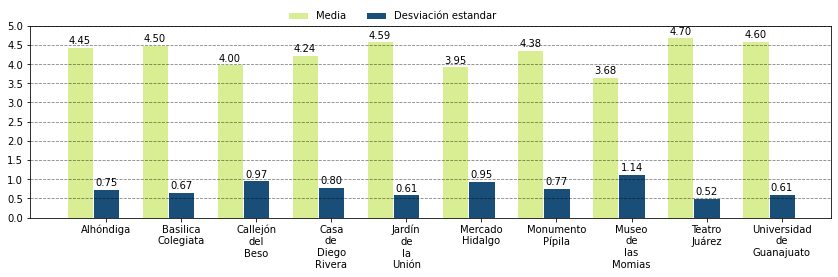

In [11]:
parameters = {"file results": "mean_std_scores.csv",
              "file graphics": "mean_std_scores.png",
              "width": 0.35,
              "y lim": 5,
              "y delta": 0.5,
              "keys": ["Mean", "std"],
              "labels": ["Media", "Desviación estandar"],
              "colors":   ["#d9ed92", "#184e77"],
              "format": "%.2f"}
results = {}
result_basis = {"Mean": 0.0,
                "std": 0.0}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    mean = tripadvisor.data["Escala"].mean()
    std = tripadvisor.data["Escala"].std()
    results[nameplace] = result_basis.copy()
    results[nameplace]["Mean"] = mean
    results[nameplace]["std"] = std
results = DataFrame(results)
results.index.name = "Results"
data = results.transpose()
plot_bars(data, dataset, parameters, show=True)

#### Opción B

Basado en palabras: longitud promedio de opiniones y desviacones estándar

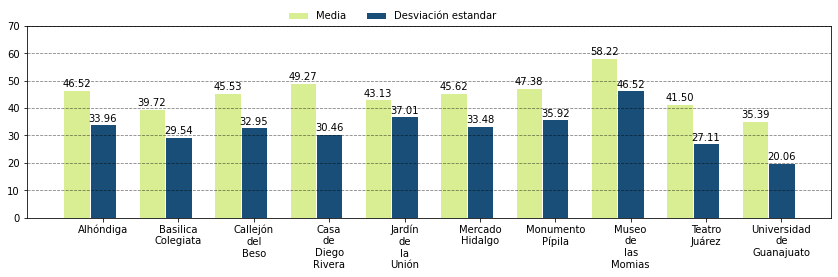

In [26]:
parameters = {"file results": "mean_std_words_length.csv",
              "file graphics": "mean_std_words_length.png",
              "width": 0.35,
              "y lim": 70,
              "y delta": 10,
              "keys": ["Mean", "std"],
              "labels": ["Media", "Desviación estandar"],
              "colors":   ["#d9ed92", "#184e77"],
              "format": "%.2f"}
results = {}
result_basis = {"Mean": 0.0,
                "std": 0.0}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    tripadvisor.obtain_word_length_per_opinion()
    mean = tripadvisor.data["Word length"].mean()
    std = tripadvisor.data["Word length"].std()
    results[nameplace] = result_basis.copy()
    results[nameplace]["Mean"] = mean
    results[nameplace]["std"] = std
results = DataFrame(results)
results.index.name = "Results"
data = results.transpose()
plot_bars(data, dataset, parameters, show=True)

#### Opción C

Histogramas de edades de opiniones por lugar

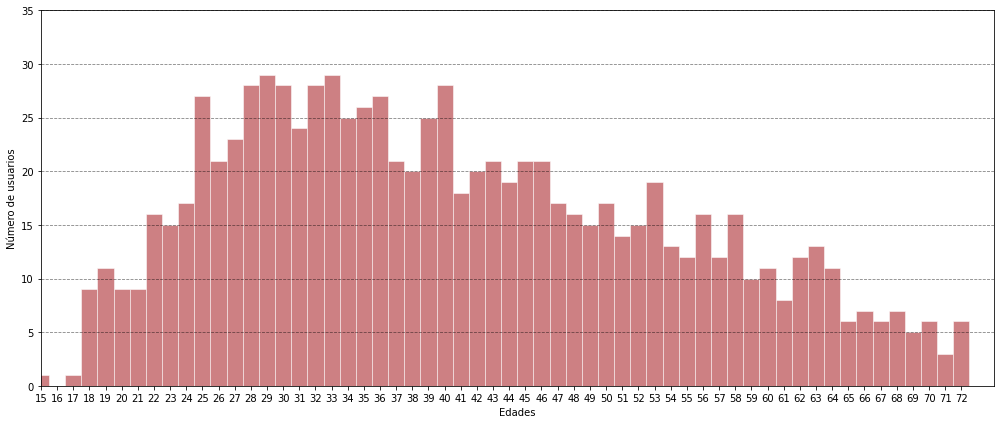

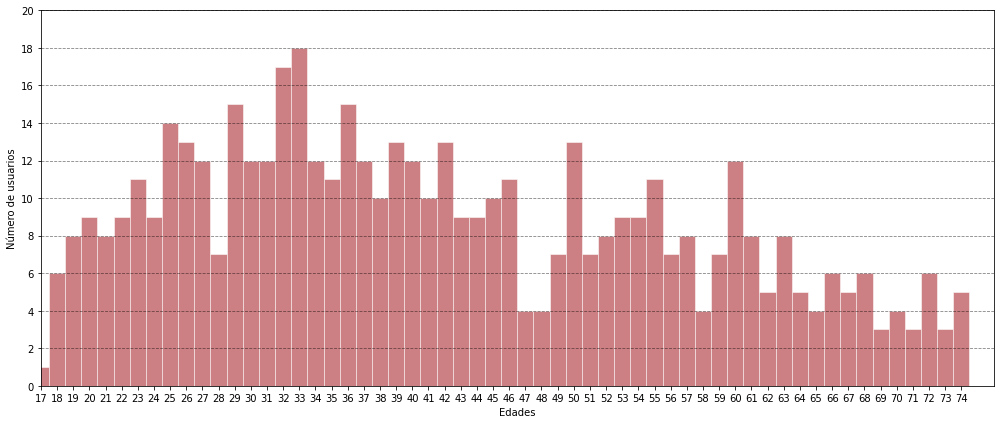

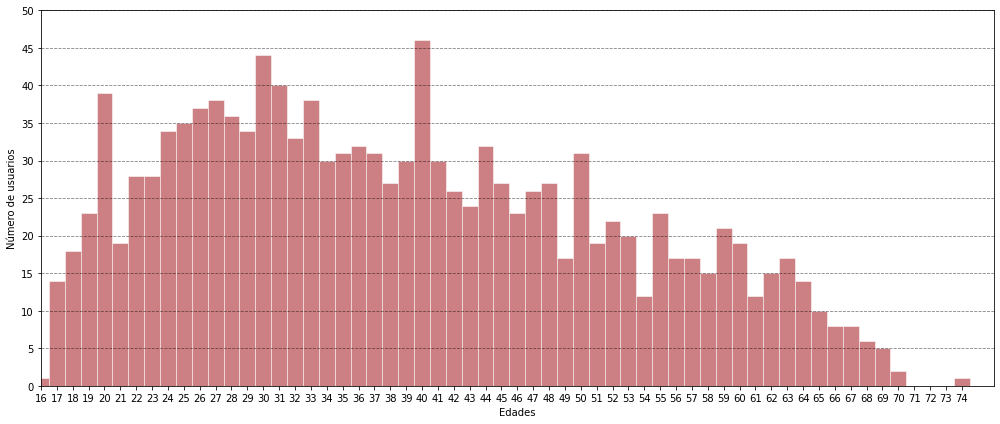

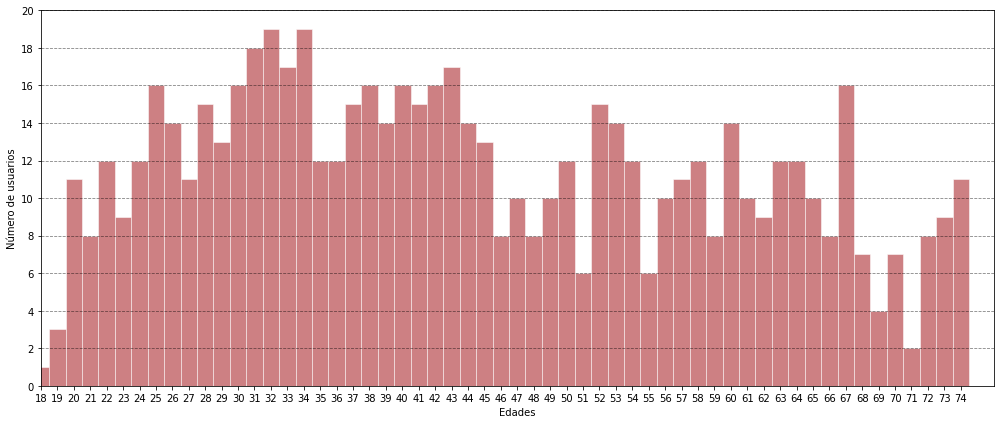

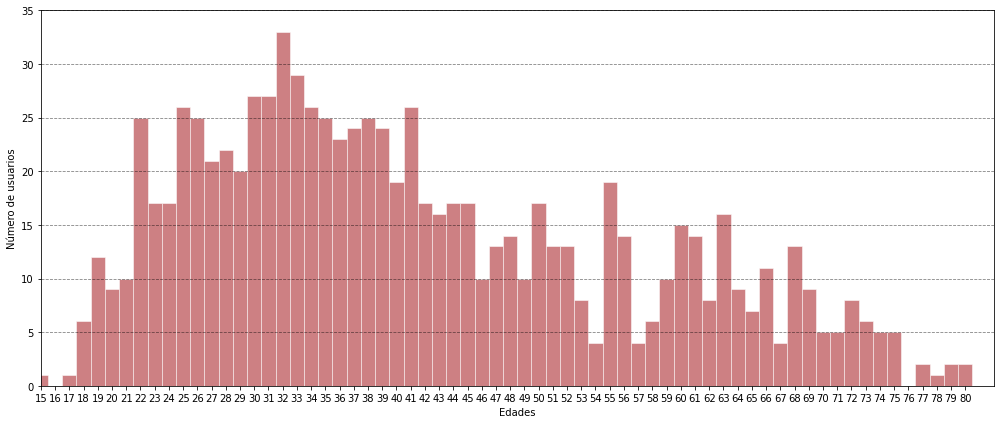

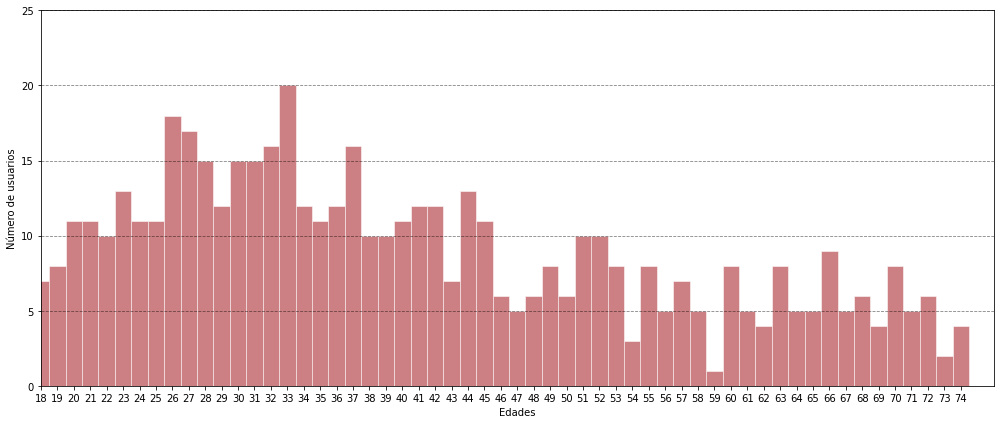

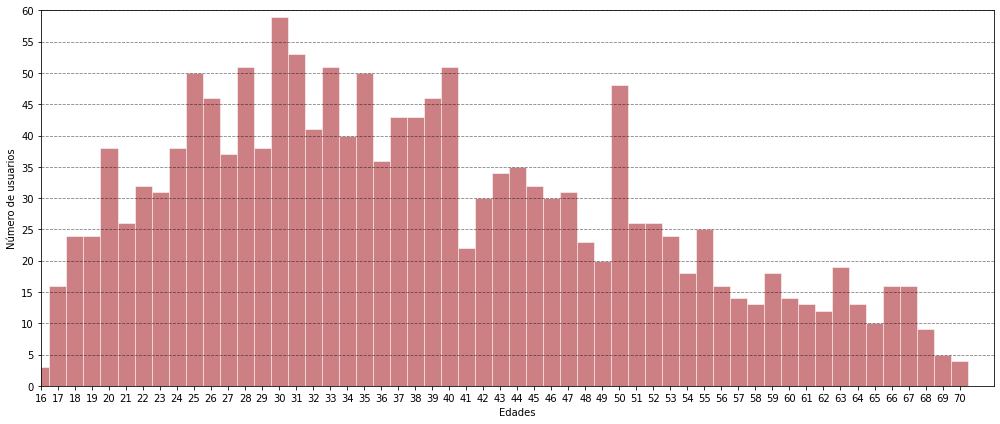

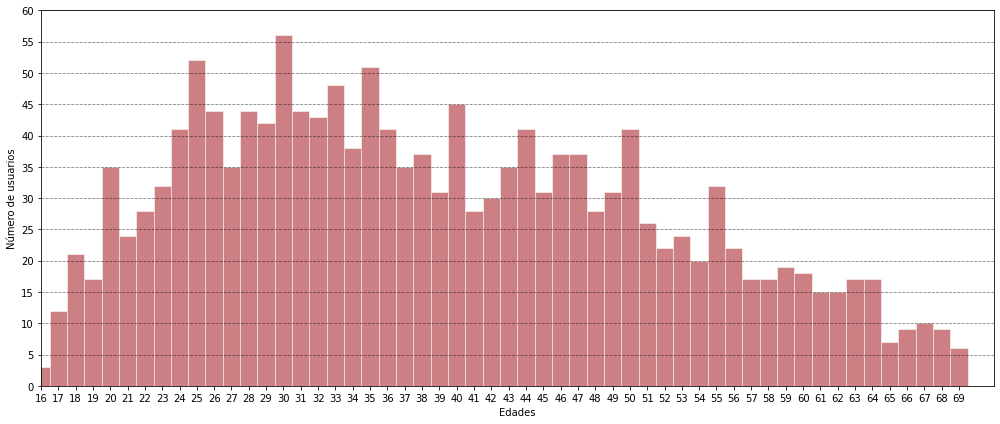

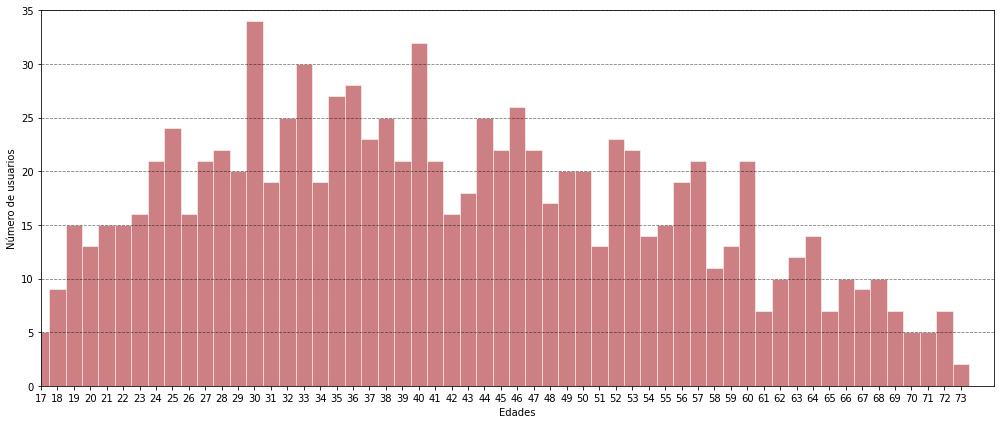

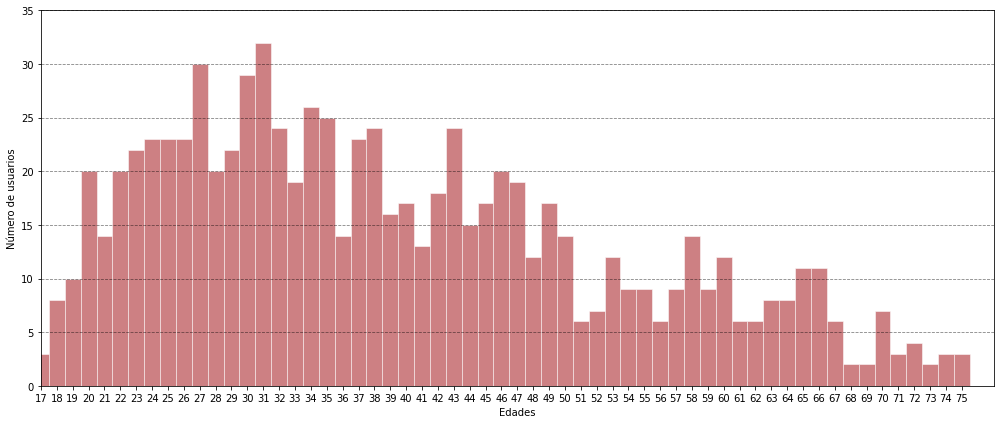

In [14]:
parameters = {"filename": ""}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    filename = file.replace(".csv", ".png")
    parameters["filename"] = filename
    plot_ages_histogram(tripadvisor.data["Edad"],
                        dataset,
                        parameters,
                        show=True)

#### Opción D

Histograma de tipo de visitantes (nacional o internacional) por lugar

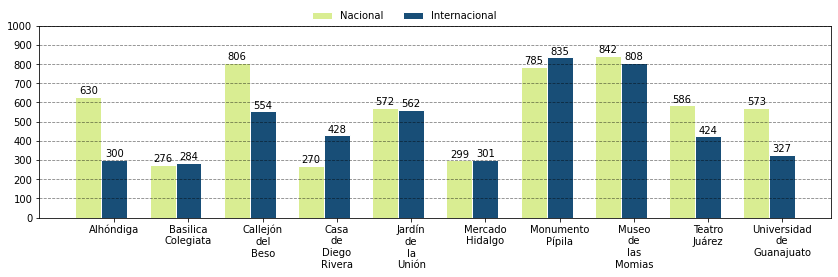

In [15]:
parameters = {"file results": "distribution_nationality.csv",
              "file graphics": "distribution_nationality.png",
              "width": 0.35,
              "y lim": 1000,
              "y delta": 100,
              "keys": ["Nacional", "Internacional"],
              "labels": ["Nacional", "Internacional"],
              "colors":   ["#d9ed92", "#184e77"],
              "format": "%.0f"}
results = {}
result_basis = {"Nacional": 0,
                "Internacional": 0}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    result = tripadvisor.data["Nacional ó Internacional"].value_counts()
    results[nameplace] = result_basis.copy()
    for key in result.keys():
        results[nameplace][key] = result[key]
results = DataFrame(results)
results.index.name = "Nationality"
data = results.transpose()
plot_bars(data, dataset, parameters, show=True)

#### Opción E

Sugiere dos más interesantes para ti.

##### Distribución de genero por cada lugar

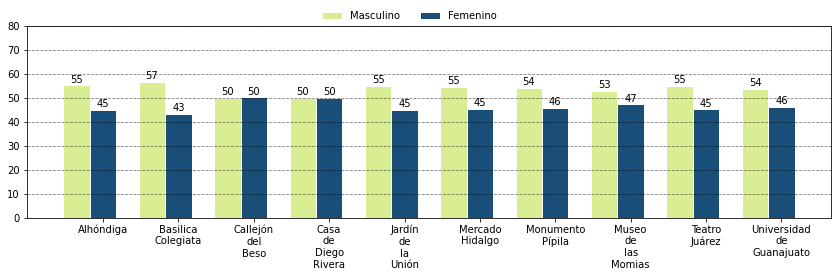

In [47]:
parameters = {"file results": "distribution_genders.csv",
              "file graphics": "distribution_genders.png",
              "width": 0.35,
              "y lim": 80,
              "y delta": 10,
              "keys": ["Masculino", "Femenino"],
              "labels": ["Masculino", "Femenino"],
              "colors":   ["#d9ed92", "#184e77"],
              "format": "%.0f"}
results = {}
result_basis = {"Masculino": 0,
                "Femenino": 0}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    result = tripadvisor.data["Género"].value_counts()
    results[nameplace] = result_basis.copy()
    for key in result.keys():
        results[nameplace][key] = result[key]
results = DataFrame(results)
results.index.name = "Gender"
dataset = parameters_model()
sum_results=results.sum()
for place in sum_results.index:
    results[place]=100*results[place]/sum_results[place]
data = results.transpose()
data = results.transpose()
plot_bars(data, dataset, parameters, show=True)

##### Distribución de las calificaciones en cada lugar

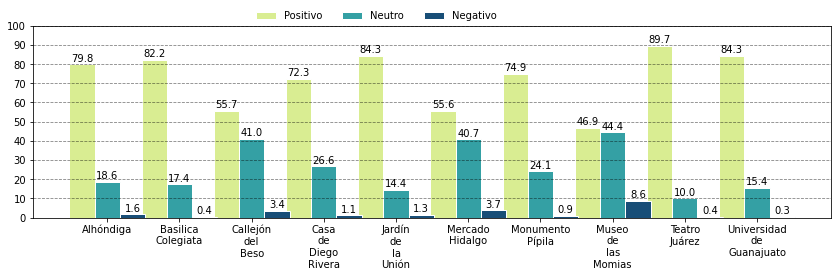

In [44]:
parameters = {"file results": "distribution_scores.csv",
              "file graphics": "distribution_scores.png",
              "width": 0.35,
              "y lim": 100,
              "y delta": 10,
              "keys": ["Positivo", "Neutro", "Negativo"],
              "labels": ["Positivo", "Neutro", "Negativo"],
              "colors":   ["#d9ed92", "#34a0a4", "#184e77"],
              "format": "%.1f"}
results = {}
result_basis = {"Positivo": 0,
                "Neutro": 0,
                "Negativo": 0}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    result = tripadvisor.data["Escala"].value_counts()
    results[nameplace] = result_basis.copy()
    for key in result.keys():
        if key in [4, 5]:
            key_name = "Positivo"
        if key in [3]:
            key_name = "Neutro"
        if key in [1, 2]:
            key_name = "Negativo"
        results[nameplace][key_name] = result[key]
results = DataFrame(results)
results.index.name = "Calificación"
sum_results=results.sum()
for place in sum_results.index:
    results[place]=100*results[place]/sum_results[place]
data = results.transpose()
plot_bars(data, dataset, parameters, show=True)

### Problema 2

Utilizando una estrategia de feature selection (se sugiere $\chi^2$ o ganancia de información) visualice con ``word_cloud`` nubes de palabras el top k (se sugiere 50) de palabras más relevantes para cada uno de los 10 lugares. Note que serán 10 nubes, una por lugar.

------------------------------------------------------------
Alhóndiga


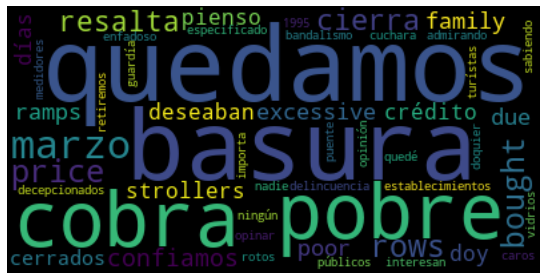

------------------------------------------------------------
Basilica Colegiata


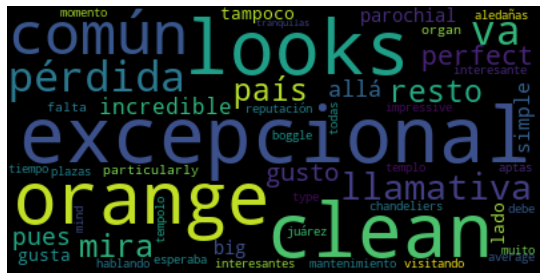

------------------------------------------------------------
Callejón del Beso


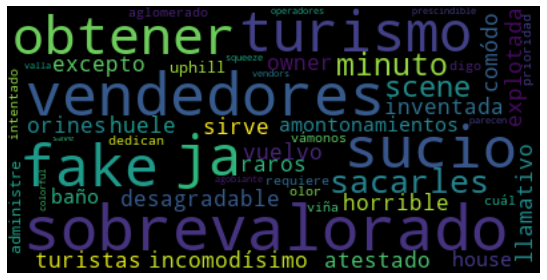

------------------------------------------------------------
Casa de Diego Rivera


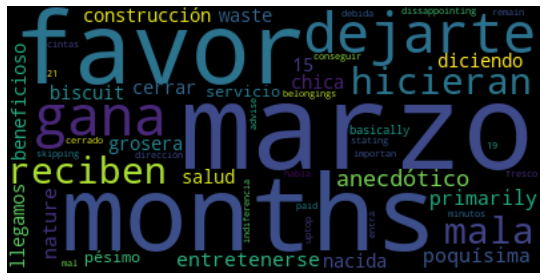

------------------------------------------------------------
Jardín de la Unión


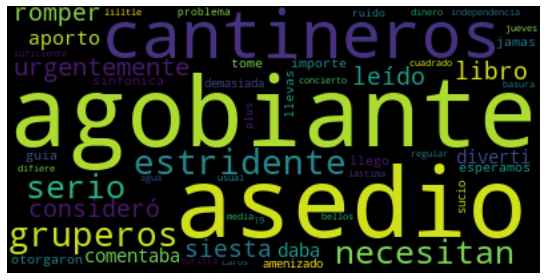

------------------------------------------------------------
Mercado Hidalgo


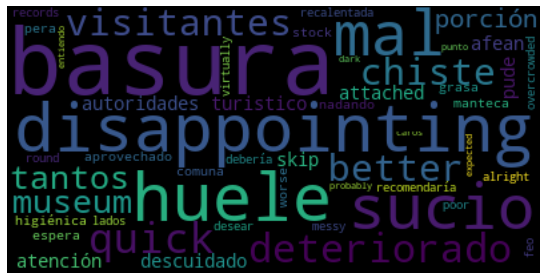

------------------------------------------------------------
Monumento Pípila


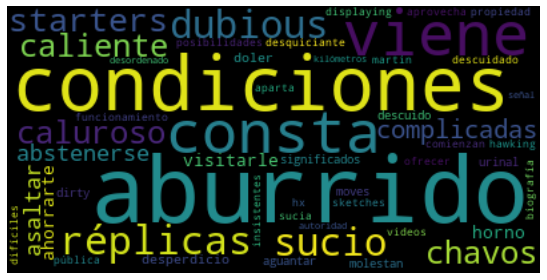

------------------------------------------------------------
Museo de las Momias


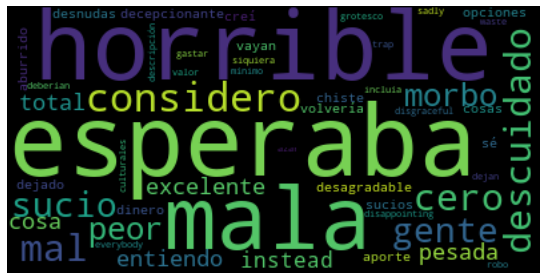

------------------------------------------------------------
Teatro Juárez


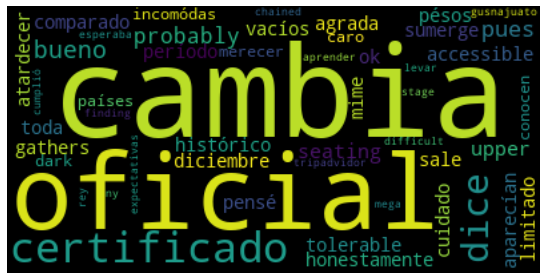

------------------------------------------------------------
Universidad de Guanajuato


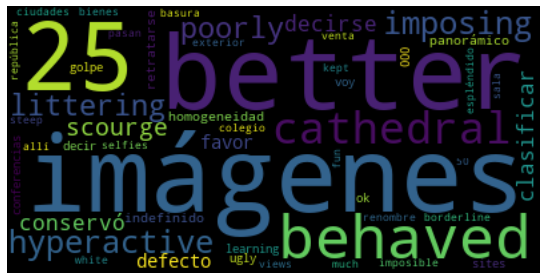

In [27]:
parameters = {"wordcloud name": ""}
results = {}
result_basis = {"Words": [],
                "Scores": []}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    print("-"*60)
    print(nameplace)
    tripadvisor.read_data(file)
    vocabulary = vocabulary_model.obtain(tripadvisor)
    word_index = dictionary.build_word_index(vocabulary)
    index_word = dictionary.build_index_word(word_index)
    binary, words = bow.build_TFIDF(tripadvisor,
                                    word_index,
                                    return_words=True)
    best_features, scores = obtain_best_features(binary,
                                                 tripadvisor.data["new scale"],
                                                 50)
    results = {}
    for index in best_features:
        results[words[index]] = scores[index]
    results = dictionary.sort_dict(results)
    results = DataFrame(results,
                        columns=["Words", "Scores"])
    results.index = results["Words"]
    results = results.drop(columns="Words")
    plot_word_cloud(results["Scores"].to_dict(),
                    dataset,
                    parameters,
                    show=True)

### Problema 3

Para cada uno de los 10 sitios turísticos, haga un descubrimiento automático de los 3 tópicos con LSA (componentes principales) más relevantes y 10 palabras contenidas en cada tópico de cada uno de los siguientes subgrupos:

#### Opción A y B

Hombres y Mujeres

In [19]:
genders = ["Masculino", "Femenino"]
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    for gender in genders:
        print("-"*40)
        print("{:>20}\tGénero: {}".format(nameplace, gender))
        tripadvisor.select_data_per_gender(gender)
        vocabulary = vocabulary_model.obtain(tripadvisor,
                                             data_select=True)
        word_index = dictionary.build_word_index(vocabulary)
        tfidf, words = bow.build_TFIDF(tripadvisor,
                                       word_index,
                                       data_select=True,
                                       return_words=True)
        lsa = LSA(tfidf, words, 3)
        lsa.obtain_words()
        lsa.obtain_top_words(10)
        print(lsa.top_words)

----------------------------------------
           Alhóndiga	Género: Masculino
     Topic 1           Topic 2    Topic 3
0   friendly             posee      makes
1  excessive             capaz       sabe
2  strollers           tiendas       tour
3      ramps       protegerlos   strongly
4       poor        trabajaban  histories
5        due           miseria      older
6     family      resguradaban       wife
7    offered  comercializacion       also
8    thought        produccion       cost
9      check           edifico      niece
----------------------------------------
           Alhóndiga	Género: Femenino
    Topic 1       Topic 2       Topic 3
0  animated       conozca        period
1  shooping         trata      detailed
2     color         quiza           men
3     strre        arriba       honored
4   venders       guardan  underwhelmed
5      year       comente           fit
6    needed  originalidad      expected
7     seats         quizà          bust
8     dirty        

         Topic 1      Topic 2        Topic 3
0            5th   recordarlo         ruinas
1   philharmonic   fotografía        solemne
2            saw      olvidar      atmósfera
3  fantastically        ícono  universitaria
4         berlin    acompañan       referido
5            6th    tranquilo      carretera
6         causal        vemos        colonia
7         sunday  majestuosos        partido
8        italian     visitada          exuda
9           cast        pagué       reciente
----------------------------------------
       Teatro Juárez	Género: Femenino
       Topic 1      Topic 2       Topic 3
0       unique         edad          site
1  participate        pleno   esstructura
2         ages          ido          sigo
3   delightful       semana      glorioso
4   encouraged     callejón  impresionada
5           73    presentan         still
6  distraction        finos        puedas
7       crowds  importancia      wondered
8      roasted   referencia         woman
9     

#### Opción C y D

Turistas Nacionales e internacionales

In [20]:
nationalities = ["Nacional", "Internacional"]
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    for nationality in nationalities:
        print("-"*40)
        print("{:>20}\tCategoria: {}".format(nameplace, nationality))
        tripadvisor.select_data_per_nationality(nationality)
        vocabulary = vocabulary_model.obtain(tripadvisor,
                                             data_select=True)
        word_index = dictionary.build_word_index(vocabulary)
        tfidf, words = bow.build_TFIDF(tripadvisor,
                                       word_index,
                                       data_select=True,
                                       return_words=True)
        lsa = LSA(tfidf, words, 3)
        lsa.obtain_words()
        lsa.obtain_top_words(10)
        print(lsa.top_words)

----------------------------------------
           Alhóndiga	Categoria: Nacional
     Topic 1      Topic 2     Topic 3
0     street       cuatro       tocar
1   shooping      ámbitos  aproximado
2      strre  antepasados    employee
3   animated  patrimonial  explaining
4      color     respeten      listen
5    venders    artístico   preserved
6    crowded     sociedad        digo
7  displayed      valoren        sale
8    visited     dirigido     tranvía
9   although       legado   definidas
----------------------------------------
           Alhóndiga	Categoria: Internacional
       Topic 1    Topic 2       Topic 3
0    narrativa  ancestors        return
1      interna     access         wells
2      pierdas        win      visitado
3       lindos      threw       mejores
4    secuencia     closer       capital
5   impecables      crept  espectacular
6  disposicion     gained         viaja
7        seria   strapped     mencionar
8     perfecta        tar     sinnumero
9      extern

      Topic 1     Topic 2          Topic 3
0      turist     enjoyed           pronto
1       heard        cine         reflejan
2        hope       medio       porfirista
3  definetely  referencia          escucha
4        talk      tantos              mal
5       never   funcional          posible
6     aguilar    terceros           verdes
7          mr    selectos          parajes
8   ascención  anfiteatro          tomamos
9        need   necesaria  entretenimiento
----------------------------------------
       Teatro Juárez	Categoria: Internacional
       Topic 1       Topic 2     Topic 3
0   identifica          door        tome
1       teoría       regular        deje
2      managua         flown    symphony
3     masónico  meticulously      mágico
4        nunca    furnishing      tarifa
5  comerciante       service        pasó
6       causas         basis   recepción
7    naturales       antique       diego
8    nicaragua       village     heavily
9       muerto      airplane  

#### Opción E y F

Jovenes (menores a 30) , mayores (mayores a 30)

In [29]:
ages = ["Joven", "Mayor"]
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    tripadvisor.read_data(file)
    for age in ages:
        print("-"*40)
        print("{:>20}\tCategoria: {}".format(nameplace, age))
        tripadvisor.select_data_per_age_range(age)
        vocabulary = vocabulary_model.obtain(tripadvisor,
                                             data_select=True)
        word_index = dictionary.build_word_index(vocabulary)
        tfidf, words = bow.build_TFIDF(tripadvisor,
                                       word_index,
                                       data_select=True,
                                       return_words=True)
        lsa = LSA(tfidf, words, 3)
        lsa.obtain_words()
        lsa.obtain_top_words(10)
        print(lsa.top_words)

----------------------------------------
           Alhóndiga	Categoria: Joven
     Topic 1      Topic 2      Topic 3
0        due     retratos        greed
1     family         apto       making
2      ramps       origen        deals
3       poor  resistencia     eventual
4  strollers      enfoque   throughout
5  excessive      antigua         gold
6      strre    población       begins
7    venders        pipil    uprisings
8   animated    escritura  catholicism
9   shooping      moderno       spread
----------------------------------------
           Alhóndiga	Categoria: Mayor
       Topic 1        Topic 2     Topic 3
0     selected      grandioso        told
1        dirty          quizà     freedom
2        seven        guardan       entry
3       needed            veo    together
4        seats        comente     fachada
5        front   originalidad  secundaria
6      alfredo        guiando    plumones
7    figurines        padecía    cuidando
8  hospitality  recordatorios     r

       Topic 1      Topic 2       Topic 3
0           73      paredes        dances
1     terrific        dejan       regions
2         corn     peatonal       vibrant
3  distraction  concurridos        friend
4   encouraged    visitenlo      talented
5       crowds        trozo  professional
6   delightful      sucedía       relatan
7       unlike        cargo      estético
8  participate    república   terminación
9      roasted    ocasiones       dominan
----------------------------------------
       Teatro Juárez	Categoria: Mayor
     Topic 1       Topic 2   Topic 3
0      stain       viernes      find
1       cast      orquesta      even
2    recited      audición      head
3    italian   filarmónica      nite
4   woodland  recomendamos    friday
5      mixed         nadar     think
6      steel   ampliamente  european
7      metal      toditito  renowned
8    created     totalidad    summer
9  designers   interesanto      till
----------------------------------------
Universidad

### Problema 4

Para cada uno de los 10 sitios turísticos, haga una nube de palabras que muestre las palabras más asociadas a sus opiniones negativas utilizando $\chi^2$ . Puede usar funciones de sklearn o hacerlo tal como en las diapositivas del autor Ricardo Baeza (diapos- itivas dónde está lo de información mutua).

Alhóndiga


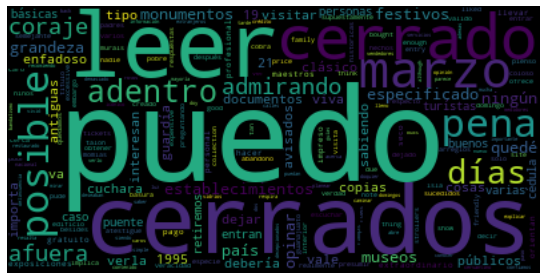

Basilica Colegiata


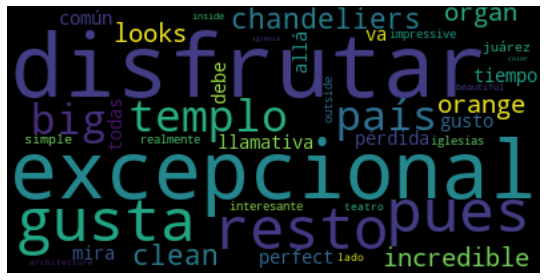

Callejón del Beso


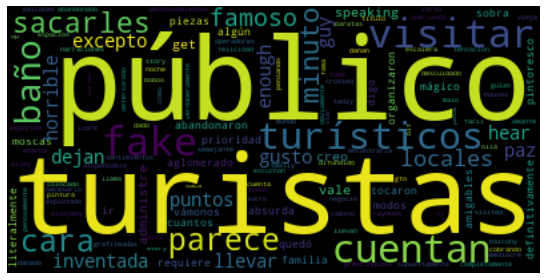

Casa de Diego Rivera


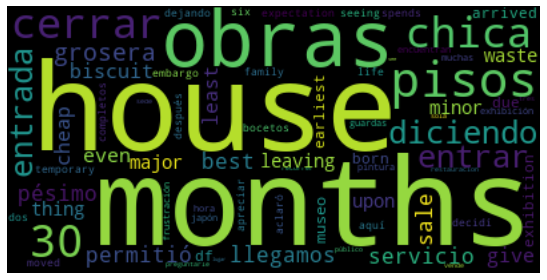

Jardín de la Unión


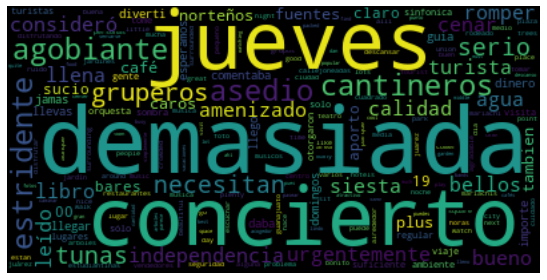

Mercado Hidalgo


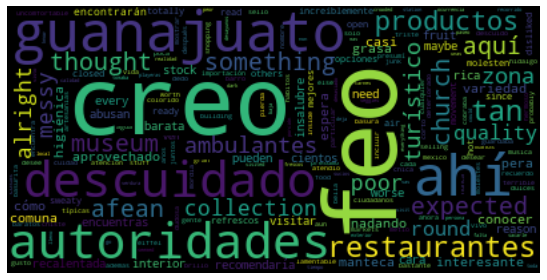

Monumento Pípila


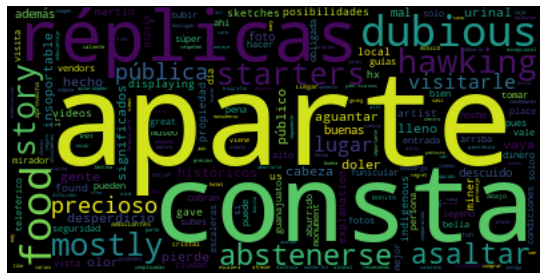

Museo de las Momias


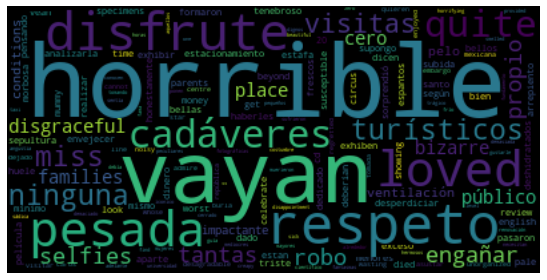

Teatro Juárez


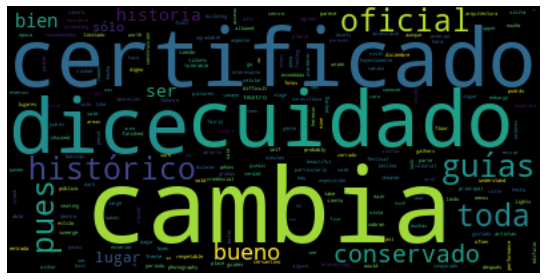

Universidad de Guanajuato


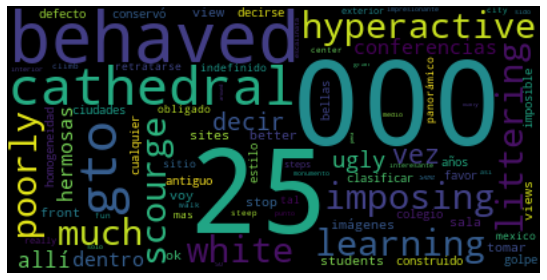

In [22]:
parameters = {"wordcloud name": ""}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    print(nameplace)
    tripadvisor.read_data(file)
    tripadvisor.obtain_only_negatives_scores()
    vocabulary = vocabulary_model.obtain(tripadvisor,
                                         data_select=True)
    word_index = dictionary.build_word_index(vocabulary)
    index_word = dictionary.build_index_word(word_index)
    bow_tfidf, words = bow.build_TFIDF(tripadvisor,
                                       word_index,
                                       data_select=True,
                                       return_words=True)
    best_features, scores = obtain_best_features(bow_tfidf,
                                                 tripadvisor.data_select["Escala"],
                                                 'all')
    results = {}
    for index in best_features:
        results[words[index]] = scores[index]
    results = dictionary.sort_dict(results)
    results = DataFrame(results,
                        columns=["Words", "Scores"])
    results.index = results["Words"]
    results = results.drop(columns="Words")
    data = results.dropna()
    plot_word_cloud(data["Scores"].to_dict(),
                    dataset,
                    parameters,
                    show=True)

### Problema 6

Muestre la ocurrencia temporal de las 10 palabras con más ganancia de información de TODO el dataset para cada sitio turístico. Aquí se sugiere usar la gráfica de estilo de los discursos de primer año de los presidentes en USA dada como ejemplo en NLTK. La idea sería tener una gráfica por sitio turístico y la ocurrencia marcada en azul del top 10 palabras de con mayor ganancia de información o chi en todo el dataset. Por ejemplo, si las 10 palabras con mayor ganancia de información en todo el dataset con respecto a las clases positivas, neutral y negativas son: $w_1,\dots,w_{10}$ entonces haga una gráfica de disperción temporal por lugar de como es la aparición de las palabras $w_1,\dots,w_{10}$ en cada sitio turistico.

Alhóndiga


Basilica Colegiata


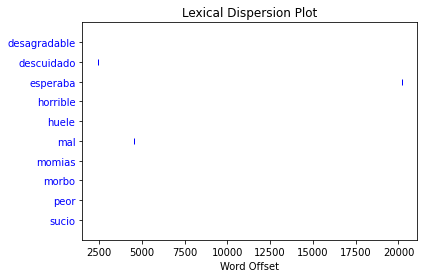

Callejón del Beso


Casa de Diego Rivera


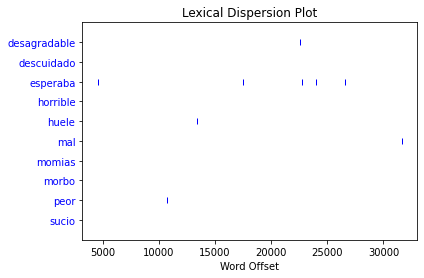

Jardín de la Unión


Mercado Hidalgo


Monumento Pípila


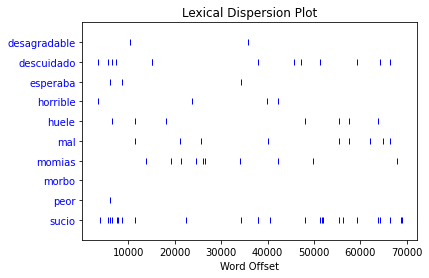

Museo de las Momias


Teatro Juárez


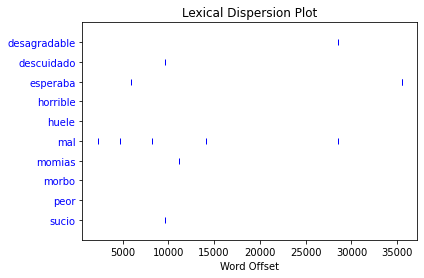

Universidad de Guanajuato


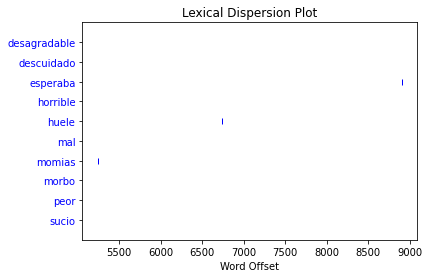

In [23]:
data = DataFrame()
# Concatenate all data
for file in files:
    tripadvisor.read_data(file)
    data = concat_dataframes(data, tripadvisor.data.copy())
tripadvisor.data = data.copy()
del data
tripadvisor.sort_by_date()
vocabulary = vocabulary_model.obtain(tripadvisor)
word_index = dictionary.build_word_index(vocabulary)
index_word = dictionary.build_index_word(word_index)
bow_tfidf, words = bow.build_TFIDF(tripadvisor,
                                   word_index,
                                   return_words=True)
best_features, scores = obtain_best_features(bow_tfidf,
                                             tripadvisor.data["new scale"],
                                             10)
words_list = []
for index in best_features:
    words_list += [words[index]]
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    print(nameplace)
    tripadvisor.read_data(file)
    tripadvisor.sort_by_date()
    opinios = tripadvisor.obtain_opinions_as_text(vocabulary_model.stopwords)
    opinios.dispersion_plot(words_list.copy())

### Problema 7

Diseñe un análisis temporal (formato libre) que muestre opiniones positivas, neg-
ativas y neutras a través de los meses y años para todos los sitios turísticos. En pocas
palabras mostrar la evolución de las opiniones a través del tiempo.

Alhóndiga


Basilica Colegiata


Callejón del Beso


Casa de Diego Rivera


Jardín de la Unión


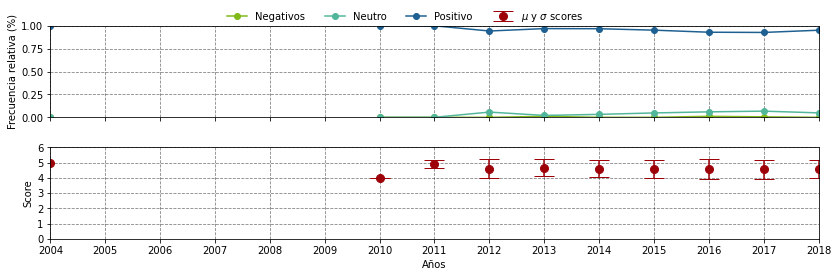

Mercado Hidalgo


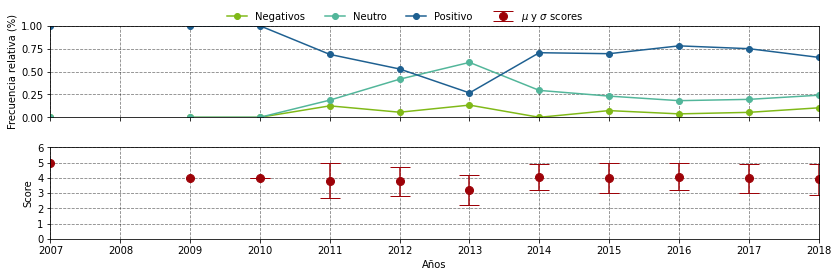

Monumento Pípila


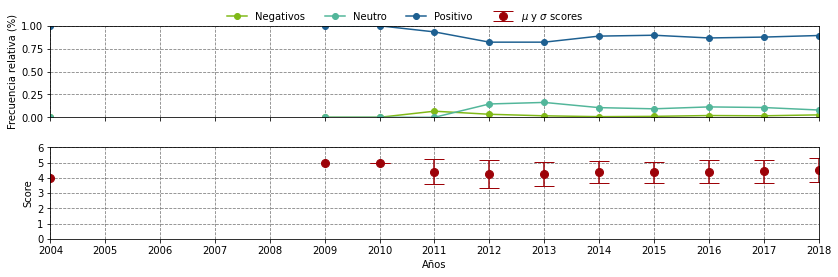

Museo de las Momias


Teatro Juárez


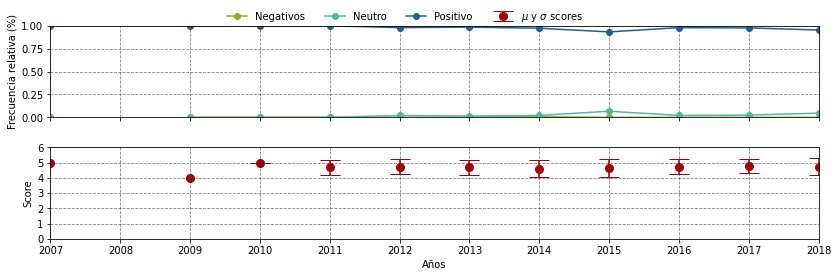

Universidad de Guanajuato


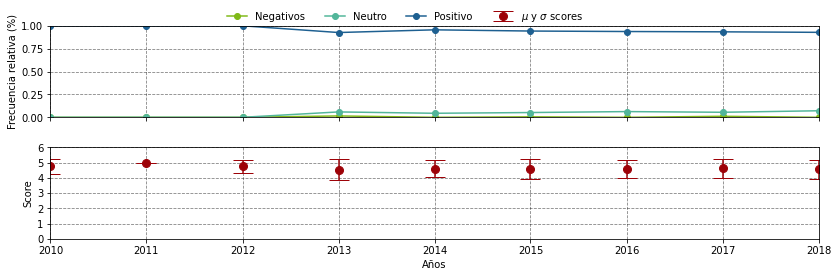

In [24]:
import warnings
# Añadido ya que en algunos dias no existe una varianza
warnings.filterwarnings("ignore")
parameters = {"file graphics": ""}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    print(nameplace)
    tripadvisor.read_data(file)
    tripadvisor.obtain_yearly_stadistics_of_scores()
    data = tripadvisor.yearly_data
    data.columns = [str(column) for column in data.columns]
    parameters["file graphics"] = file.replace(".csv", ".png")
    plot_yearly_results(data, dataset, parameters, show=True)

Alhóndiga


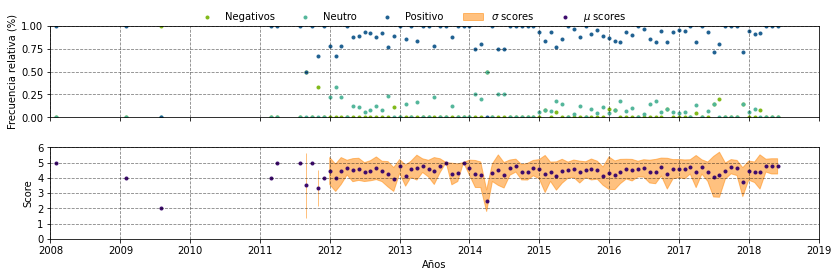

Basilica Colegiata


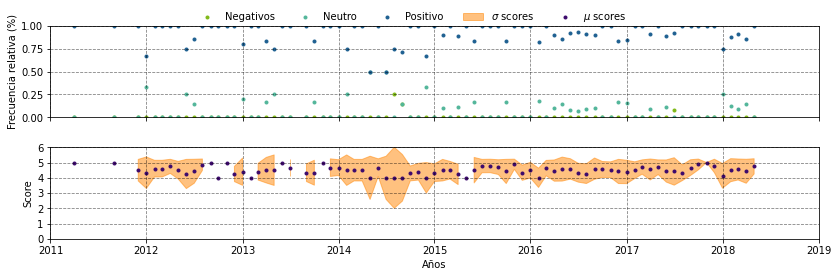

Callejón del Beso


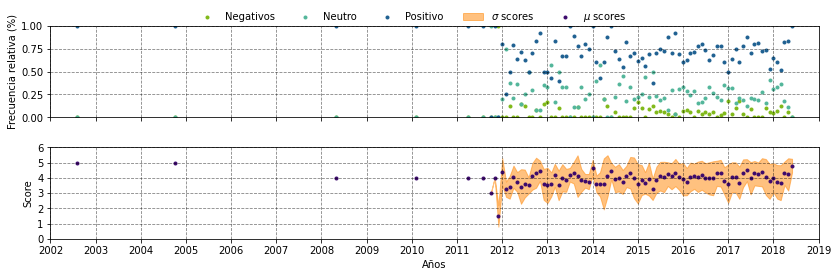

Casa de Diego Rivera


Jardín de la Unión


Mercado Hidalgo


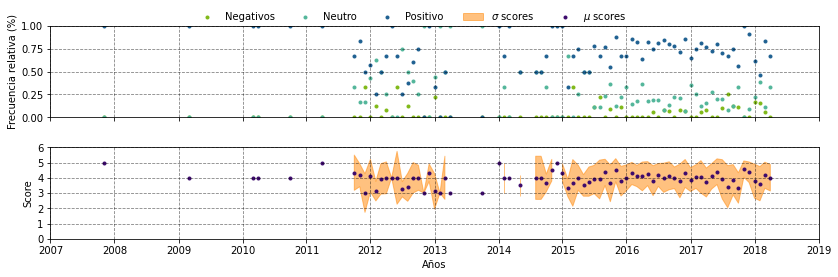

Monumento Pípila


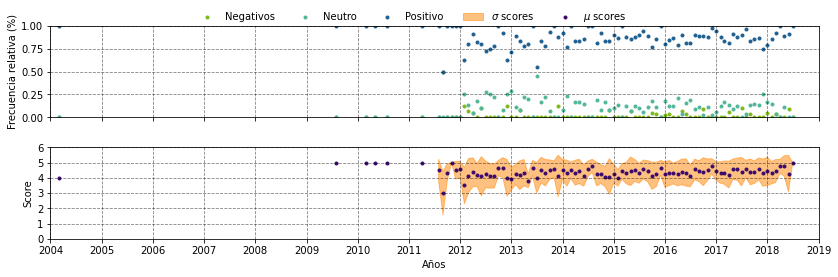

Museo de las Momias


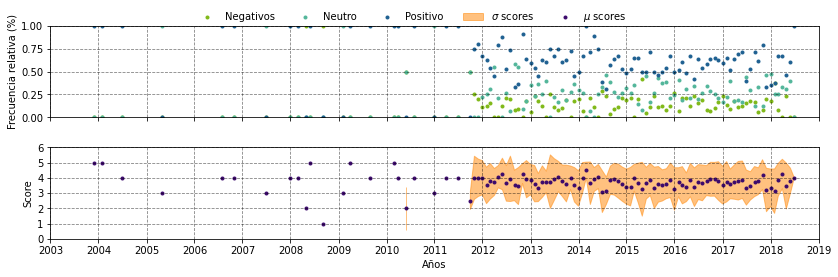

Teatro Juárez


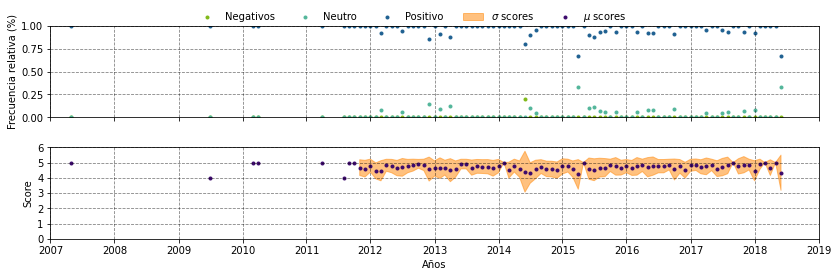

Universidad de Guanajuato


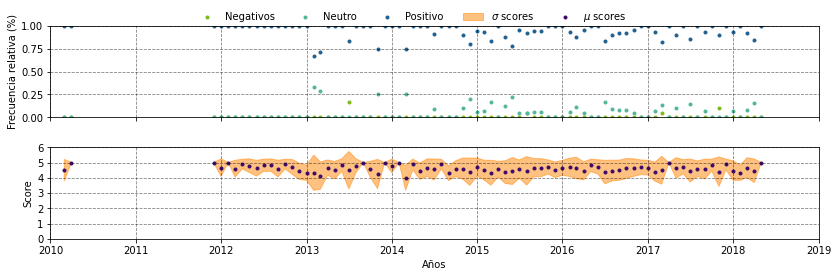

In [25]:
parameters = {"file graphics": ""}
for file in files:
    nameplace = obtain_name_place_from_filename(file)
    print(nameplace)
    filename = join_path(dataset.parameters["path results"],
                         file)
    tripadvisor.read_data(file)
    tripadvisor.obtain_monthly_stadistics_of_scores()
    data = tripadvisor.monthly_data
    data.columns = [str(column) for column in data.columns]
    parameters["file graphics"] = file.replace(".csv", ".png")
    plot_monthly_results(data, dataset, parameters, show=True)

### Preguntas: 

Conteste lo más detallado posible lo siguiente, dando argumentos y conclusiones claras según su análisis previo. Cada respuesta entre 150 y 300 palabras.

##### Preguna 1

+ ¿De los sitios turísticos, cual diría usted que es el más polémico y la razón de
ello?

Del sitio turístico que es más polémico es el museo de las momias debido a la cantidad de opiniones negativas y neutras es mayor con respecto a las demás locaciones. La evolución temporal de las calificaciones dadas por los usuarios refleja una poca variación entre la cantidad de calificaciones positivas, neutras y negativas. Por lo que podriamos afirmar que las opiniones de este lugar son invariantes al tipo de personas que acuden al lugar. En general la mayoria de las personas opinan de igual manera. Las palabras con mayor representación en este lugar que se obtuvo por cada tipo de persona (hombre, mujer, mayor, joven, internacional o nacional) hacen un énfasis en como este lugar es oscuro, tiene una sensación lugubre, que esta descuidado o que puede dar una sensación incomoda, Por ende es razonable que el lugar contenga una gran cantidad de opiniones negativas, ya que este tipo de opiniones representan lo que es el museo.

##### Pregunta 2

+ En cuanto al sitio más polémico, ¿Como es la diferencia de opinión y temas entre
turistas nacionales e internacionales?

Las opiniones de los turistas nacionales e internacionales difieren en que los turistas nacionales dan opiniones de las actividades o dificultades que se tienen para llegar al lugar en cuestión. En cambio los tusitas internacionales se enfocaron más en el precio y las condicionees en las que se encuentra lugar turistico. Esto puede ser debido a que los turistas nacionales pueden tener un contexto más cercano y por ende una idea de que esperarse adentro del lugar. Por otro lado los turistas internacionales pueden esperar algo más pulcro o con mejor presentación. 

##### Pregunta 3

+ ¿Cual diría que es el sitio que le gusta más a las mujeres y por qué?



##### Pregunta 4

+ ¿Cual diría que es el sitio que le gusta más a las personas jóvenes y por qué?

##### Pregunta 5

+ ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó de que se queja la gente? ¿qué tipo de cosas le gustó a la gente?, etc.)